In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from wmfdata import mariadb, charting

%matplotlib inline
charting.set_mpl_style()

In [2]:
# CHANGE THIS FOR A NEW MONTH!
# The time range for which to update. START is included, END is excluded.
START = "201810"
END = "201811"

# Update table

In [3]:
# Create table if necessary
mariadb.run("""
CREATE TABLE IF NOT EXISTS staging.editor_month (
  `wiki` varbinary(255) NOT NULL,
  `month` date NOT NULL,
  `local_user_id` int(10) unsigned NOT NULL,
  `user_name` varbinary(255) NOT NULL DEFAULT '',
  `edits` int(10) unsigned NOT NULL DEFAULT '0',
  `content_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `deleted_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `mobile_web_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `mobile_app_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `visual_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `ve_source_edits` int(10) unsigned NOT NULL DEFAULT '0',
  `bot_flag` tinyint(1) NOT NULL DEFAULT '0',
  `user_registration` datetime DEFAULT NULL,
  PRIMARY KEY (`wiki`,`month`,`local_user_id`),
  KEY `wiki_user` (`wiki`,`user_name`),
  KEY `user_name` (`user_name`),
  KEY `month_wiki` (`month`,`wiki`)
) 
ENGINE=InnoDB
DEFAULT CHARSET=binary
COMMENT='See documentation at https://meta.wikimedia.org/wiki/Research:Editor_month_dataset' 
""")

# Get the SQL update command from the file.
with open("queries/update_editor_month.sql") as f:
    update_cmd = f.read()

# Updated data is constantly inserted into the MariaDB replicas. We don't want these operations
# to block that.
isolate_cmd = "set session transaction isolation level read uncommitted;"
update_cmd = update_cmd.format(start=START, end=END)

# Select and insert the new rows from each wiki
mariadb.multirun([isolate_cmd, update_cmd])

aawiki completed in 0 s
aawikibooks completed in 1 s
aawiktionary completed in 0 s
abwiki completed in 2 s
abwiktionary completed in 0 s
acewiki completed in 1 s
adywiki completed in 1 s
afwiki completed in 2 s
afwikibooks completed in 1 s
afwikiquote completed in 0 s
afwiktionary completed in 1 s
akwiki completed in 1 s
akwikibooks completed in 0 s
akwiktionary completed in 0 s
alswiki completed in 1 s
alswikibooks completed in 0 s
alswikiquote completed in 0 s
alswiktionary completed in 0 s
amwiki completed in 1 s
amwikiquote completed in 1 s
amwiktionary completed in 0 s
angwiki completed in 1 s
angwikibooks completed in 0 s
angwikiquote completed in 0 s
angwikisource completed in 0 s
angwiktionary completed in 0 s
anwiki completed in 1 s
anwiktionary completed in 1 s
arcwiki completed in 1 s
arwiki completed in 147 s
arwikibooks completed in 0 s
arwikinews completed in 1 s
arwikiquote completed in 0 s
arwikisource completed in 1 s
arwikiversity completed in 0 s
arwiktionary complet

# Quality checks

In [5]:
editors = mariadb.run("""
select
    month,
    count(*) as editors,
    sum(content_edits >= 100) as very_active_editors
from staging.editor_month 
where month >= "2015-10-01"
group by month
""")

editors = (
    editors
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

editors.tail()

,editors,very_active_editors
month,,
2018-06-01,363298,14871.0
2018-07-01,360069,15151.0
2018-08-01,366679,15689.0
2018-09-01,382912,15324.0
2018-10-01,397804,15502.0


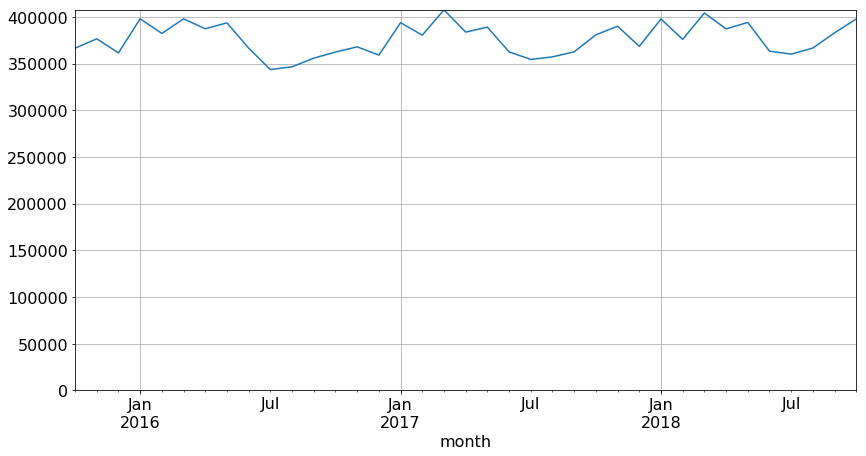

In [8]:
editors["editors"].plot(ylim=0)

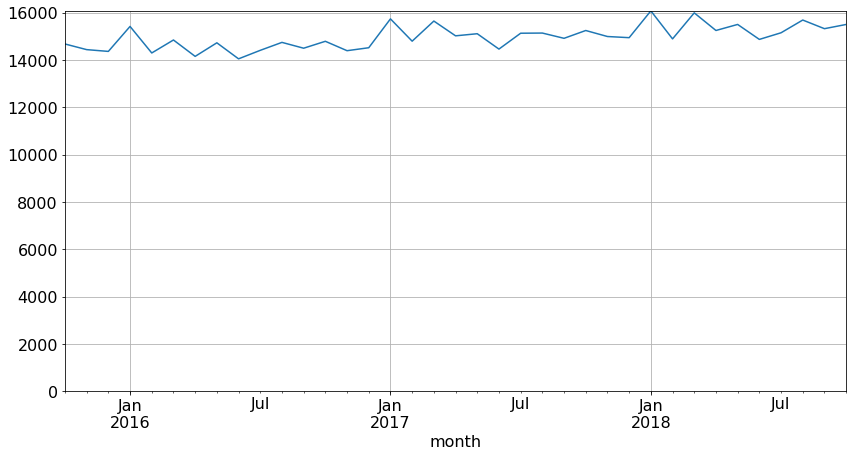

In [9]:
editors["very_active_editors"].plot(ylim=0)

In [10]:
editors_per_wiki = mariadb.run("""
select
    month,
    wiki,
    count(*) as editors 
from staging.editor_month 
where
    month >= "2017-11-01" and
    wiki in ("arwiki", "dewiki", "enwiki", "kowiki", "zhwiki")
group by wiki, month
""")

editors_per_wiki = (
    editors_per_wiki
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
    .pivot(columns="wiki")
    .xs("editors", axis=1)
)

editors_per_wiki.tail()

wiki,arwiki,dewiki,enwiki,kowiki,zhwiki
month,,,,,
2018-06-01,4561,18428,125067,2358,8053
2018-07-01,4744,18927,126144,2221,8738
2018-08-01,5012,19347,129490,2284,8842
2018-09-01,5735,18876,131050,2243,7852
2018-10-01,5651,20403,141664,2344,8384


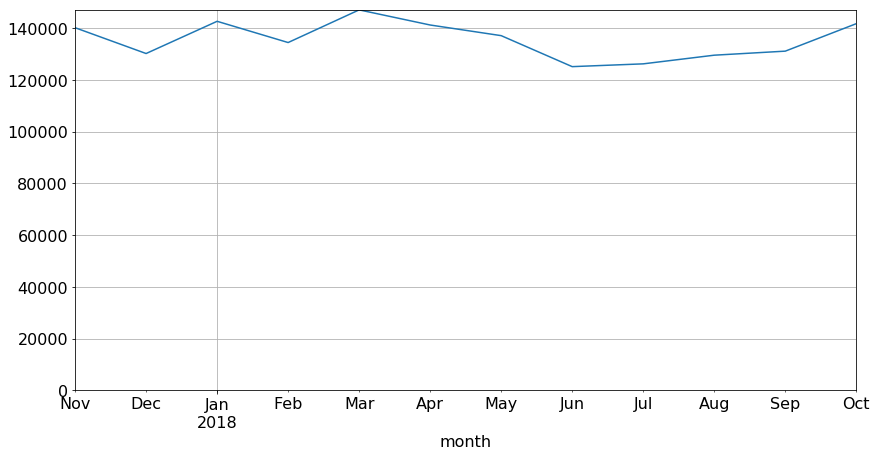

In [12]:
editors_per_wiki["enwiki"].plot(ylim=0);

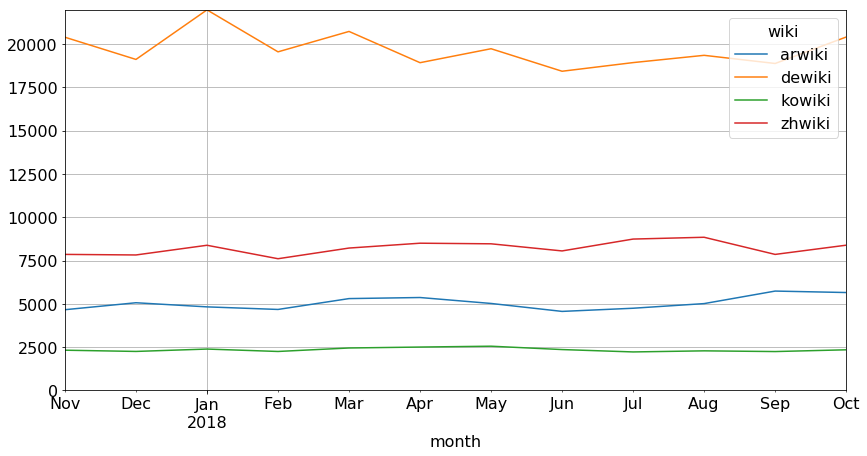

In [24]:
editors_per_wiki.drop("enwiki", axis=1).plot(ylim=0);